<a href="https://www.kaggle.com/code/trishul15/dermnet?scriptVersionId=265917967" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# =========================
# Cell 1: Setup & sanity
# =========================

import os, glob, random, math, csv, time, gc
from pathlib import Path

import numpy as np
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

# Paths (adjust if needed)
train_images = "/kaggle/input/isicxx-segdatasets/ISIC18_Resized_SegData/Train/Images"
train_masks  = "/kaggle/input/isicxx-segdatasets/ISIC18_Resized_SegData/Train/Masks"
val_images   = "/kaggle/input/isicxx-segdatasets/ISIC18_Resized_SegData/Val/Images"
val_masks    = "/kaggle/input/isicxx-segdatasets/ISIC18_Resized_SegData/Val/Masks"
test_images  = "/kaggle/input/isicxx-segdatasets/ISIC18_Resized_SegData/Test/Images"
test_masks   = "/kaggle/input/isicxx-segdatasets/ISIC18_Resized_SegData/Test/Masks"

# Quick dimension check (optional)
def list_unique_sizes(img_dir):
    sizes = []
    for f in os.listdir(img_dir):
        p = os.path.join(img_dir, f)
        if os.path.isfile(p):
            try:
                sizes.append(Image.open(p).size)
            except:
                pass
    return set(sizes)

print("Train image dimensions:", list_unique_sizes(train_images))
print("Train mask  dimensions:", list_unique_sizes(train_masks))
print("Val   image dimensions:", list_unique_sizes(val_images))
print("Val   mask  dimensions:", list_unique_sizes(val_masks))
print("Test  image dimensions:", list_unique_sizes(test_images))
print("Test  mask  dimensions:", list_unique_sizes(test_masks))

# Global knobs
IMG_SIZE    = 256         # 256 is a great accuracy/compute trade-off; can try 320 later
BATCH_SIZE  = 18
NUM_WORKERS = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Working dirs
BASE_DIR   = "/kaggle/working"
PRED_DIR   = f"{BASE_DIR}/predictions"
os.makedirs(PRED_DIR, exist_ok=True)



Train image dimensions: {(224, 224)}
Train mask  dimensions: {(224, 224)}
Val   image dimensions: {(224, 224)}
Val   mask  dimensions: {(224, 224)}
Test  image dimensions: {(224, 224)}
Test  mask  dimensions: {(224, 224)}
Device: cuda


In [2]:
# ===========================================
# Cell 2 (fixed): Augmentations, data
# ===========================================
import albumentations as A
from albumentations.pytorch import ToTensorV2

def make_noise_aug():
    try:
        _ = A.GaussNoise(p=0.2)
        return A.GaussNoise(p=0.2)
    except Exception:
        return A.GaussianBlur(blur_limit=(3, 7), p=0.2)

noise_aug = make_noise_aug()

# Use size=(H,W) for RandomResizedCrop to satisfy current Albumentations schema
train_transform = A.Compose(
    [
        A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=15,
                           border_mode=cv2.BORDER_REFLECT_101, p=0.5),
        A.RandomBrightnessContrast(0.2, 0.2, p=0.5),
        A.HueSaturationValue(10, 15, 10, p=0.3),
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.25),
        noise_aug,
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

# Explicit height/width to avoid schema mismatch
val_transform = A.Compose(
    [
        A.Resize(height=IMG_SIZE, width=IMG_SIZE, interpolation=cv2.INTER_LINEAR),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

def quick_artifact_pseudomasks(img_rgb: np.ndarray):
    img = img_rgb.copy()
    h, w, _ = img.shape

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L = lab[:, :, 0]
    blackhat = cv2.morphologyEx(
        L, cv2.MORPH_BLACKHAT, cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    )
    _, hair = cv2.threshold(blackhat, 30, 255, cv2.THRESH_BINARY)

    edges = cv2.Canny(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 80, 160)
    lines = cv2.HoughLinesP(
        edges, 1, np.pi / 180, threshold=60,
        minLineLength=int(0.2 * max(h, w)), maxLineGap=10
    )
    ruler = np.zeros((h, w), np.uint8)
    if lines is not None:
        for l in lines[:100]:
            x1, y1, x2, y2 = l[0]
            cv2.line(ruler, (x1, y1), (x2, y2), 255, 2)

    spec = cv2.inRange(img, (220, 220, 220), (255, 255, 255))

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    skin = cv2.inRange(hsv, (0, 10, 40), (25, 255, 255)) | \
           cv2.inRange(hsv, (160, 10, 40), (179, 255, 255))
    skin = cv2.medianBlur(skin, 5)

    return {
        "hair": (hair > 0).astype(np.uint8),
        "ruler": (ruler > 0).astype(np.uint8),
        "specular": (spec > 0).astype(np.uint8),
        "skinbg": (skin > 0).astype(np.uint8),
    }

def img2mask_path(img_path, masks_dir):
    base = os.path.basename(img_path)
    stem, _ = os.path.splitext(base)
    mask_name = f"{stem}_segmentation.png"
    p = os.path.join(masks_dir, mask_name)
    if not os.path.exists(p):
        raise FileNotFoundError(f"Mask not found for {img_path} → expected {p}")
    return p

class LesionDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transforms, training=False):
        self.images_dir = images_dir
        self.masks_dir  = masks_dir
        self.transforms = transforms
        self.training   = training

        exts = ("*.png", "*.jpg", "*.jpeg", "*.tif", "*.bmp")
        files = []
        for e in exts:
            files.extend(glob.glob(os.path.join(images_dir, e)))
        self.img_paths = sorted(files)
        assert len(self.img_paths) > 0, f"No images in {images_dir}"
        _ = [img2mask_path(p, masks_dir) for p in self.img_paths]

    def __len__(self): return len(self.img_paths)

    def __getitem__(self, idx):
        ip = self.img_paths[idx]
        mp = img2mask_path(ip, self.masks_dir)

        img = cv2.imread(ip, cv2.IMREAD_COLOR)[:, :, ::-1]
        msk = cv2.imread(mp, cv2.IMREAD_GRAYSCALE)
        msk = (msk > 127).astype(np.uint8)

        # Build artifact pseudo-labels (4 channels)
        art = quick_artifact_pseudomasks(img)
        art_target  = np.stack([art["hair"], art["ruler"], art["specular"], art["skinbg"]], axis=0)  # 4,H,W
        # Dermoscopic placeholders (6 channels)
        derm_target = np.zeros((6, img.shape[0], img.shape[1]), dtype=np.uint8)                      # 6,H,W

        # Albumentations requires masks list with each item HxW (2D)
        masks_list = [art_target[c] for c in range(art_target.shape[0])] + \
                 [derm_target[c] for c in range(derm_target.shape[0])]

        if self.training:
            aug = train_transform(image=img, mask=msk, masks=masks_list)
        else:
            aug = val_transform(image=img, mask=msk, masks=masks_list)

        # image tensor already via ToTensorV2
        img_t = aug["image"]  # C,H,W (float tensor)

        # mask may be np or torch depending on albumentations version; normalize to torch
        if isinstance(aug["mask"], torch.Tensor):
            msk_t = aug["mask"].unsqueeze(0).float()  # 1,H,W
        else:
            msk_t = torch.from_numpy(aug["mask"]).unsqueeze(0).float()

        # Re-stack artifacts (first 4) and dermoscopic (next 6) from aug["masks"]
    def to_tensor_2d(x):
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

        aug_masks = aug["masks"]
        art_t  = torch.stack([to_tensor_2d(aug_masks[i]).float() for i in range(4)], dim=0)     # 4,H,W
        derm_t = torch.stack([to_tensor_2d(aug_masks[4+i]).float() for i in range(6)], dim=0)   # 6,H,W

        return img_t, msk_t, art_t, derm_t, os.path.basename(ip)

# Build loaders
train_ds = LesionDataset(train_images, train_masks, train_transform, training=True)
val_ds   = LesionDataset(val_images,   val_masks,   val_transform,   training=False)
test_ds  = LesionDataset(test_images,  test_masks,  val_transform,   training=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


(2594, 100, 1000)

In [3]:
# ======================================================
# Cell 2b: Robust Dataset (retry) + rebuild DataLoaders
# ======================================================
import random
from torch.utils.data._utils.collate import default_collate

MAX_RETRIES = 8

def _to_tensor_image(x):
    if isinstance(x, torch.Tensor):
        return x
    assert isinstance(x, np.ndarray)
    if x.ndim == 3 and x.shape[0] in (1, 3):    # C,H,W
        return torch.from_numpy(x).float()
    return torch.from_numpy(x.transpose(2, 0, 1)).float()  # H,W,C -> C,H,W

def _to_tensor_mask2d(x):
    return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

class LesionDataset(LesionDataset):
    def __getitem__(self, idx):
        # Try current idx, then random fallback up to MAX_RETRIES
        for _ in range(MAX_RETRIES):
            try:
                ip = self.img_paths[idx]
                mp = img2mask_path(ip, self.masks_dir)

                img = cv2.imread(ip, cv2.IMREAD_COLOR)
                if img is None:
                    raise RuntimeError("image read failed")
                img = img[:, :, ::-1]  # BGR->RGB

                msk = cv2.imread(mp, cv2.IMREAD_GRAYSCALE)
                if msk is None:
                    raise RuntimeError("mask read failed")
                msk = (msk > 127).astype(np.uint8)

                art = quick_artifact_pseudomasks(img)
                art_target  = np.stack([art["hair"], art["ruler"], art["specular"], art["skinbg"]], axis=0)  # 4,H,W
                derm_target = np.zeros((6, img.shape[0], img.shape[1]), dtype=np.uint8)                      # 6,H,W

                masks_list = [art_target[c] for c in range(4)] + [derm_target[c] for c in range(6)]

                aug = (train_transform if self.training else val_transform)(
                    image=img, mask=msk, masks=masks_list
                )

                img_t = _to_tensor_image(aug["image"])
                msk_t = _to_tensor_mask2d(aug["mask"]).unsqueeze(0).float()

                aug_masks = aug.get("masks", None)
                if (aug_masks is None) or (len(aug_masks) < 10):
                    # If Albumentations dropped something, rebuild defensive
                    # Fill missing with zeros of same HxW
                    H, W = int(msk_t.shape[-2]), int(msk_t.shape[-1])
                    need = 10 if aug_masks is None else (10 - len(aug_masks))
                    aug_masks = (aug_masks or []) + [torch.zeros((H, W), dtype=torch.float32)] * need

                art_t  = torch.stack([_to_tensor_mask2d(aug_masks[i]).float() for i in range(4)], dim=0)     # 4,H,W
                derm_t = torch.stack([_to_tensor_mask2d(aug_masks[4+i]).float() for i in range(6)], dim=0)   # 6,H,W

                return img_t, msk_t, art_t, derm_t, os.path.basename(ip)

            except Exception:
                # pick a different index and retry
                idx = random.randrange(0, len(self.img_paths))

        # ---- Fallback (very rare): synthetic zero sample to keep loop going ----
        H = W = IMG_SIZE
        img_t  = torch.zeros(3, H, W, dtype=torch.float32)
        msk_t  = torch.zeros(1, H, W, dtype=torch.float32)
        art_t  = torch.zeros(4, H, W, dtype=torch.float32)
        derm_t = torch.zeros(6, H, W, dtype=torch.float32)
        return img_t, msk_t, art_t, derm_t, f"fallback_{idx}.png"

# Optional: simple collate; after this fix we don't expect None items
def simple_collate(batch):
    return default_collate(batch)

# Rebuild datasets & loaders
train_ds = LesionDataset(train_images, train_masks, train_transform, training=True)
val_ds   = LesionDataset(val_images,   val_masks,   val_transform,   training=False)
test_ds  = LesionDataset(test_images,  test_masks,  val_transform,   training=False)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True, drop_last=True,
    collate_fn=simple_collate, persistent_workers=False
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True,
    collate_fn=simple_collate, persistent_workers=False
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True,
    collate_fn=simple_collate, persistent_workers=False
)

print("✔ Robust Dataset active. DataLoaders rebuilt (no None items expected).")
print("Lens — Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))


✔ Robust Dataset active. DataLoaders rebuilt (no None items expected).
Lens — Train: 2594 Val: 100 Test: 1000


In [4]:
# ==========================================
# Cell 3: Losses, targets, metrics, helpers
# ==========================================
# GroupNorm picker
def GN(c: int) -> nn.GroupNorm:
    for g in (8, 6, 4, 3, 2, 1):
        if c % g == 0:
            return nn.GroupNorm(g, c)
    return nn.GroupNorm(1, c)

# Dice Loss (probabilistic)
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6): 
        super().__init__(); self.eps = eps
    def forward(self, logits, targets):
        p = torch.sigmoid(logits)
        num = 2 * (p * targets).sum(dim=(2,3)) + self.eps
        den = (p.pow(2) + targets.pow(2)).sum(dim=(2,3)) + self.eps
        return 1 - (num / den).mean()

# Lovasz hinge for IoU
def lovasz_grad(gt_sorted):
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union.clamp(min=1)
    if jaccard.numel() > 1:
        jaccard[1:] = jaccard[1:] - jaccard[:-1]
    return jaccard

def lovasz_hinge_flat(logits, labels):
    if logits.numel() == 0:
        return logits * 0.
    signs = 2. * labels - 1.
    errors = 1. - logits * signs
    errors_sorted, perm = torch.sort(errors, descending=True)
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.elu(errors_sorted) + 1, grad) / logits.numel()
    return loss

def lovasz_hinge(logits, targets):
    logits = logits.view(logits.size(0), -1)
    targets = targets.view(targets.size(0), -1)
    return torch.mean(torch.stack([lovasz_hinge_flat(l, t) for l, t in zip(logits, targets)]))

# Thin ring edges for boundary supervision
@torch.no_grad()
def make_edge_targets(masks: torch.Tensor, k: int = 3) -> torch.Tensor:
    if k % 2 == 0:
        k = k + 1
    pad = k // 2
    dil = F.max_pool2d(masks, kernel_size=k, stride=1, padding=pad)
    ero = 1.0 - F.max_pool2d(1.0 - masks, kernel_size=k, stride=1, padding=pad)
    edge = (dil - ero).clamp_min(0.0)
    return (edge > 0).float()

# Signed Distance Map (normalized)
@torch.no_grad()
def signed_distance_map(masks: torch.Tensor, max_radius: int = 32) -> torch.Tensor:
    """
    masks: (B,1,H,W) in {0,1}
    returns: (B,1,H,W) float32 in [-1, 1]
    Computes inside/outside distances on padded tensors, then crops back.
    """
    b, _, h, w = masks.shape
    pad = max_radius

    m   = F.pad(masks, (pad, pad, pad, pad), value=0.0)
    inv = 1.0 - m

    def chamfer(x):
        # crude iterative chamfer distance via max-pool propagation
        d = torch.full_like(x, 1e6)
        d = torch.where(x > 0.5, torch.zeros_like(d), d)
        for _ in range(max_radius):
            d = torch.minimum(d, F.max_pool2d(d + 1, kernel_size=3, stride=1, padding=1))
        return d

    d_out = chamfer(inv)[:, :, pad:-pad, pad:-pad]  # outside distance
    d_in  = chamfer(m)[:, :, pad:-pad, pad:-pad]    # inside distance
    sd = (d_in - d_out) / float(max_radius)
    return sd.clamp(-1.0, 1.0)


# ABCD weak targets computed from mask & image
@torch.no_grad()
def abcd_targets(imgs: torch.Tensor, masks: torch.Tensor):
    b, _, h, w = masks.shape
    A_list, B_list, C_list, D_list = [], [], [], []
    # de-normalize roughly
    imgs_np = (imgs.detach().cpu().numpy() * np.array([0.229,0.224,0.225]).reshape(1,3,1,1) + 
               np.array([0.485,0.456,0.406]).reshape(1,3,1,1))
    for i in range(b):
        m = masks[i,0].detach().cpu().numpy().astype(np.uint8)
        area = m.sum()
        if area < 10:
            A_list.append(0.0); B_list.append(0.0); C_list.append(0.0); D_list.append(0.0); continue

        left, right = np.hsplit(m, 2)
        top, bottom = np.vsplit(m, 2)
        ax = abs(left.sum() - right.sum()) / (area + 1e-6)
        ay = abs(top.sum() - bottom.sum()) / (area + 1e-6)
        A_score = float((ax + ay) / 2.0)

        contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            B_score = 0.0
        else:
            P = float(cv2.arcLength(contours[0], True))
            circ = (P * P) / (4.0 * np.pi * (area + 1e-6))
            B_score = float(np.tanh((circ - 1.0)))

        img = (imgs_np[i].transpose(1,2,0).clip(0,1) * 255).astype(np.uint8)
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        vals = hsv[m.astype(bool)]
        C_score = float(np.tanh(vals.std() / 64.0))

        radius = np.sqrt(area / np.pi)
        diameter = 2.0 * radius
        diag = np.sqrt(h*h + w*w)
        D_score = float(diameter / (diag + 1e-6))

        A_list.append(A_score); B_list.append(B_score); C_list.append(C_score); D_list.append(D_score)

    toT = lambda x: torch.tensor(x, dtype=torch.float32, device=imgs.device).unsqueeze(1)
    return {"A": toT(A_list), "B": toT(B_list), "C": toT(C_list), "D": toT(D_list)}

# Metrics
@torch.no_grad()
def metrics_from_logits(logits, targets, thr=0.5, eps=1e-6):
    if isinstance(logits, dict):
        logits = logits["logits"]
    probs = torch.sigmoid(logits)
    preds = (probs > thr).float()
    tp = (preds * targets).sum(dim=(2,3))
    fp = (preds * (1 - targets)).sum(dim=(2,3))
    fn = ((1 - preds) * targets).sum(dim=(2,3))
    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    iou  = (tp + eps) / (tp + fp + fn + eps)
    return dice.mean().item(), iou.mean().item()

# Edge-weighted loss helpers
def edge_weight_map(masks, max_w=2.0, radius=5):
    e = make_edge_targets(masks, k=radius)
    return 1.0 + (max_w - 1.0) * e

def weighted_bce_dice(logits, targets, wmap):
    p = torch.sigmoid(logits)
    bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    bce_loss = (bce_loss * wmap).mean()
    num = 2 * (p*targets*wmap).sum(dim=(2,3)) + 1e-6
    den = ((p*p + targets*targets)*wmap).sum(dim=(2,3)) + 1e-6
    dice_loss = 1 - (num/den).mean()
    return 0.5*bce_loss + 0.5*dice_loss

# Focal BCE for multi-label heads
def focal_bce_with_logits(logits, targets, alpha=0.25, gamma=2.0):
    p = torch.sigmoid(logits)
    ce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    pt = targets * p + (1 - targets) * (1 - p)
    loss = ce * ((1 - pt) ** gamma)
    if alpha is not None:
        loss = alpha * targets * loss + (1 - alpha) * (1 - targets) * loss
    return loss.mean()

# Heteroscedastic weighting (aleatoric)
def gaussian_nll(residual, logvar):
    return 0.5 * torch.exp(-logvar) * (residual ** 2) + 0.5 * logvar

# EMA
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {k: v.detach().clone() for k, v in model.state_dict().items() if v.dtype.is_floating_point}
    @torch.no_grad()
    def update(self, model):
        for k, v in model.state_dict().items():
            if k in self.shadow and v.dtype.is_floating_point:
                self.shadow[k].mul_(self.decay).add_(v.detach(), alpha=1 - self.decay)
    @torch.no_grad()
    def apply_to(self, model):
        sd = model.state_dict()
        sd.update(self.shadow)
        model.load_state_dict(sd, strict=False)


In [5]:
# =======================================================
# Cell 4: Model (base + multi-task) & optimizer/scheduler
# =======================================================

# ---- Lightweight depthwise U-Net backbone with LACM & boundary head ----
class SeperableConv(nn.Module):
    def __init__(self, cin, cout, dilation=1):
        super().__init__()
        pad = dilation
        self.dw = nn.Conv2d(cin, cin, 3, padding=pad, dilation=dilation, groups=cin, bias=False)
        self.bn1 = GN(cin)
        self.pw = nn.Conv2d(cin, cout, 1, bias=False)
        self.bn2 = GN(cout)
        self.act = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.act(self.bn1(self.dw(x)))
        x = self.act(self.bn2(self.pw(x)))
        return x

class DoubleSeperableConv(nn.Module):
    def __init__(self, cin, cout, dropout_p=0.0, dilation=1):
        super().__init__()
        self.c1 = SeperableConv(cin, cout, dilation=dilation)
        self.c2 = SeperableConv(cout, cout, dilation=1)
        self.drop = nn.Dropout2d(dropout_p) if dropout_p > 0 else nn.Identity()
    def forward(self, x):
        return self.drop(self.c2(self.c1(x)))

class Up(nn.Module):
    def __init__(self, cin, cout, skip_in, skip_proj_to):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.reduce = nn.Conv2d(cin, cout, 1, bias=False)
        self.bn_up = GN(cout)
        self.skip_proj = nn.Conv2d(skip_in, skip_proj_to, 1, bias=False)
        self.bn_skip = GN(skip_proj_to)
        self.act = nn.ReLU(inplace=True)
    def forward(self, x, skip):
        x = self.act(self.bn_up(self.reduce(self.up(x))))
        skip = self.act(self.bn_skip(self.skip_proj(skip)))
        return torch.cat([x, skip], dim=1)

class LACM(nn.Module):
    def __init__(self, channels, dilations=(1,3,5), reduction=2):
        super().__init__()
        br_c = channels // reduction
        self.branches = nn.ModuleList([SeperableConv(channels, br_c, dilation=d) for d in dilations])
        fused_in = br_c * len(dilations)
        self.fuse = nn.Sequential(
            nn.Conv2d(fused_in, channels, 1, bias=False),
            GN(channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        feats = [b(x) for b in self.branches]
        return self.fuse(torch.cat(feats, dim=1))

class BoundaryRefinementHead(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, 3, padding=1, bias=False),
            GN(in_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_ch, 1, 1)
        )
    def forward(self, x):
        bl = self.conv(x)
        bp = torch.sigmoid(bl)
        return bp, bl

class UNetDW512_BR_LACM(nn.Module):
    def __init__(self, bottleneck_drop=0.1):
        super().__init__()
        self.enc1 = DoubleSeperableConv(3,   32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleSeperableConv(32,  64)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleSeperableConv(64,  112)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleSeperableConv(112, 160)

        self.lacm   = LACM(160, dilations=(1,3,5), reduction=2)
        self.bottle = DoubleSeperableConv(160, 224, dropout_p=bottleneck_drop)

        self.up1 = Up(cin=224, cout=112, skip_in=112, skip_proj_to=56)
        self.dec1 = DoubleSeperableConv(168, 112)
        self.up2 = Up(cin=112, cout=56,  skip_in=64,  skip_proj_to=32)
        self.dec2 = DoubleSeperableConv(88,  56)
        self.up3 = Up(cin=56,  cout=28,  skip_in=32,  skip_proj_to=16)
        self.dec3 = DoubleSeperableConv(44,  32)

        self.brh  = BoundaryRefinementHead(32)

    def forward_feats(self, x):
        e1 = self.enc1(x)                  # 1x
        e2 = self.enc2(self.pool1(e1))     # 1/2
        e3 = self.enc3(self.pool2(e2))     # 1/4
        e4 = self.enc4(self.pool3(e3))     # 1/8

        c  = self.lacm(e4)
        b  = self.bottle(c)

        x3 = self.dec1(self.up1(b, e3))    # ~1/4 scale features
        x2 = self.dec2(self.up2(x3, e2))   # ~1/2
        x1 = self.dec3(self.up3(x2, e1))   # 1x

        boundary_prob, boundary_logits = self.brh(x1)
        x1 = x1 * (1.0 + boundary_prob)    # residual edge gating

        return x3, x2, x1, boundary_logits

# ---- Multi-task wrapper with deep supervision + uncertainty ----
class MultiTaskUNet(nn.Module):
    def __init__(self, dermo_classes=6, artifact_classes=4):
        super().__init__()
        self.base = UNetDW512_BR_LACM(bottleneck_drop=0.1)
        ch = 32  # last decoder channels

        # Main heads
        self.mask_head = nn.Conv2d(ch, 1, 1)
        self.sdm_head  = nn.Conv2d(ch, 1, 1)
        self.art_head  = nn.Conv2d(ch, artifact_classes, 1)
        self.derm_head = nn.Conv2d(ch, dermo_classes, 1)

        # Deep supervision (aux heads at 1/4 and 1/2 scales)
        self.aux1 = nn.Conv2d(112, 1, 1)  # from x3
        self.aux2 = nn.Conv2d(56,  1, 1)  # from x2

        # ABCD global attributes
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.abcd_mlp = nn.Sequential(
            nn.Conv2d(ch, 64, 1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 8, 1),  nn.ReLU(inplace=True),
        )
        self.abcd_out = nn.Conv2d(8, 4, 1)  # A,B,C,D regression

        # Aleatoric uncertainty for main mask loss
        self.logvar_mask = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        x3, x2, x1, boundary_logits = self.base.forward_feats(x)
        mask_logits = self.mask_head(x1)
        sdm         = self.sdm_head(x1)
        art         = self.art_head(x1)
        derm        = self.derm_head(x1)

        aux1 = self.aux1(x3)
        aux2 = self.aux2(x2)

        g = self.abcd_out(self.abcd_mlp(self.gap(x1)))  # B,4,1,1
        abcd = g.flatten(1)  # B,4

        return {
            "logits": mask_logits,
            "aux1": aux1,
            "aux2": aux2,
            "boundary_logits": boundary_logits,
            "sdm": sdm,
            "artifact_logits": art,
            "dermo_logits": derm,
            "abcd": abcd,
            "logvar_mask": self.logvar_mask
        }

# ---- Instantiate model & optim ----
model = MultiTaskUNet().to(device)

# Optimizer / Scheduler / AMP / EMA
opt     = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4, betas=(0.9, 0.999))
epochs  = 120
sched   = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=1e-6)
scaler  = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))
ema     = EMA(model, decay=0.999)

print("Model ready.")


Model ready.


/tmp/ipykernel_36/70873747.py:173: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler  = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))


In [6]:
# ======================================================
# Cell 5: Curriculum, losses, train/eval step functions
# ======================================================
bce   = nn.BCEWithLogitsLoss()
diceL = DiceLoss()
huber = nn.SmoothL1Loss()

def stage_weights(epoch):
    if epoch <= 10:
        return dict(w_main=1.0, w_bound=0.10, w_sdm=0.0, w_art=0.0, w_abcd=0.0, derm_w=0.0, edge_k=3, lovasz=True, aux_w=0.3)
    elif epoch <= 25:
        return dict(w_main=1.0, w_bound=0.15, w_sdm=0.3, w_art=0.0, w_abcd=0.0, derm_w=0.0, edge_k=3, lovasz=True, aux_w=0.3)
    elif epoch <= 50:
        return dict(w_main=1.0, w_bound=0.15, w_sdm=0.3, w_art=0.3, w_abcd=0.0, derm_w=0.0, edge_k=3, lovasz=True, aux_w=0.25)
    else:
        return dict(w_main=1.0, w_bound=0.15, w_sdm=0.3, w_art=0.3, w_abcd=0.2, derm_w=0.2, edge_k=3, lovasz=True, aux_w=0.2)

def multitask_loss(batch, output, step_cfg):
    imgs, lesion, art, derm = batch

    # Edge-weighted main
    wmap = edge_weight_map(lesion, max_w=2.0, radius=5)
    main = weighted_bce_dice(output["logits"], lesion, wmap)
    if step_cfg["lovasz"]:
        main = main + 0.2 * lovasz_hinge(output["logits"], lesion)

    # Deep supervision auxiliaries (upscale to full size)
    aux1_up = F.interpolate(output["aux1"], size=lesion.shape[-2:], mode="bilinear", align_corners=False)
    aux2_up = F.interpolate(output["aux2"], size=lesion.shape[-2:], mode="bilinear", align_corners=False)
    aux_loss = 0.5*(diceL(aux1_up, lesion) + bce(aux1_up, lesion)) + \
               0.5*(diceL(aux2_up, lesion) + bce(aux2_up, lesion))

    # Boundary
    edges = make_edge_targets(lesion, k=step_cfg["edge_k"])
    b_loss = bce(output["boundary_logits"], edges)

    # SDM (regression on tanh head to [-1,1])
    sdm_t = signed_distance_map(lesion)
    sdm_loss = huber(torch.tanh(output["sdm"]), sdm_t)

    # Artifacts (multi-label)
    art_loss  = focal_bce_with_logits(output["artifact_logits"], art, alpha=0.25, gamma=2.0)

    # Dermoscopic (enable later via derm_w)
    derm_w = step_cfg["derm_w"]
    derm_loss = focal_bce_with_logits(output["dermo_logits"], derm) if derm_w > 0 else torch.tensor(0.0, device=imgs.device)

    # ABCD (weak regression)
    abcd_t   = abcd_targets(imgs, lesion)
    abcd_pred = output["abcd"]
    abcd_gt   = torch.cat([abcd_t["A"], abcd_t["B"], abcd_t["C"], abcd_t["D"]], dim=1)
    abcd_loss = huber(abcd_pred, abcd_gt)

    # Aleatoric weighting on main
    s = output["logvar_mask"].clamp(-2.5, 2.5)   # s = log(σ^2), clamped for stability
    main_aleatoric = (main * torch.exp(-s)) + s

    total = (
        step_cfg["w_main"] * main_aleatoric +
        step_cfg["aux_w"]  * aux_loss +
        step_cfg["w_bound"]* b_loss +
        step_cfg["w_sdm"]  * sdm_loss +
        step_cfg["w_art"]  * art_loss +
        derm_w             * derm_loss +
        step_cfg["w_abcd"] * abcd_loss
    )

    parts = dict(
        main=float(main.item()),
        main_aleatoric=float(main_aleatoric.item()),
        aux=float(aux_loss.item()),
        boundary=float(b_loss.item()),
        sdm=float(sdm_loss.item()),
        art=float(art_loss.item()),
        derm=float(derm_loss.item()) if derm_w>0 else 0.0,
        abcd=float(abcd_loss.item()),
    )
    return total, parts

from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler(enabled=(device == "cuda"))

def train_step(batch, step_cfg):
    model.train()
    imgs, lesion, art, derm, _ = batch
    imgs, lesion, art, derm = imgs.to(device), lesion.to(device), art.to(device), derm.to(device)

    opt.zero_grad(set_to_none=True)

    with torch.amp.autocast("cuda", enabled=(device == "cuda")):
        out = model(imgs)
        loss, parts = multitask_loss((imgs, lesion, art, derm), out, step_cfg)
    scaler.scale(loss).backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    scaler.step(opt); scaler.update()
    ema.update(model)
    return loss.item(), parts

@torch.no_grad()
def eval_step(batch, step_cfg, use_ema=True, thr=0.5):
    if use_ema:
        ema.apply_to(model)
    model.eval()
    imgs, lesion, art, derm, _ = batch
    imgs, lesion, art, derm = imgs.to(device), lesion.to(device), art.to(device), derm.to(device)

    with torch.amp.autocast("cuda", enabled=(device == "cuda")):
        out = model(imgs)
        loss, _ = multitask_loss((imgs, lesion, art, derm), out, step_cfg)

    d, i = metrics_from_logits(out["logits"], lesion, thr=thr)
    return loss.item(), d, i


/tmp/ipykernel_36/1385179475.py:81: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device == "cuda"))


In [7]:
# ==========================================
# Reset DataLoaders with safe_collate guard
# ==========================================
from torch.utils.data._utils.collate import default_collate

# 1) Safe collate that drops None samples coming from Dataset.__getitem__
def safe_collate(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    return default_collate(batch)

# 2) (Optional) Re-wrap Dataset.__getitem__ defensively again in case of redefs
#    If you already have the robust LesionDataset from earlier, you can skip re-defining it.
try:
    _ = LesionDataset  # should exist already
except NameError:
    raise RuntimeError("LesionDataset is not defined. Run your Dataset/Augmentations cell first.")

# 3) Rebuild datasets
train_ds = LesionDataset(train_images, train_masks, train_transform, training=True)
val_ds   = LesionDataset(val_images,   val_masks,   val_transform,   training=False)
test_ds  = LesionDataset(test_images,  test_masks,  val_transform,   training=False)

# 4) Rebuild loaders using safe_collate explicitly.
#    Also set persistent_workers=False so workers pick up the NEW collate in notebooks.
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True, drop_last=True,
    collate_fn=safe_collate, persistent_workers=False
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True,
    collate_fn=safe_collate, persistent_workers=False
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True,
    collate_fn=safe_collate, persistent_workers=False
)

print(" DataLoaders rebuilt with safe_collate.")
print("Lengths — Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))
print("Collate fns:", train_loader.collate_fn, val_loader.collate_fn, test_loader.collate_fn)


 DataLoaders rebuilt with safe_collate.
Lengths — Train: 2594 Val: 100 Test: 1000
Collate fns: <function safe_collate at 0x79d9aabff740> <function safe_collate at 0x79d9aabff740> <function safe_collate at 0x79d9aabff740>


In [ ]:
# ==========================================================
# Cell 6 (final UI): Train loop + rich logging + thr/T fit
# ==========================================================
from tqdm import tqdm

LOG_CSV   = f"{BASE_DIR}/train_log.csv"
CKPT_BEST = f"{BASE_DIR}/edge_mtd_isl18_best.pt"

if not os.path.exists(LOG_CSV):
    with open(LOG_CSV, "w", newline="") as f:
        csv.writer(f).writerow([
            "epoch","lr",
            "train_loss","val_loss","val_dice","val_iou",
            "train_main","train_boundary","train_sdm","train_aux","train_art","train_derm","train_abcd"
        ])

best_val_dice = -1.0
no_improve    = 0
PATIENCE      = 3

try:
    for epoch in range(1, epochs + 1):
        step_cfg = stage_weights(epoch)

        # ----------------- TRAIN -----------------
        tloss = 0.0
        n_train = 0
        comp_sums = {k:0.0 for k in ["main","boundary","sdm","aux","art","derm","abcd"]}
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [train]")
        for batch in pbar:
            bs = batch[0].size(0)
            loss, parts = train_step(batch, step_cfg)
            tloss += loss * bs
            n_train += bs
            for k in comp_sums:
                comp_sums[k] += parts.get(k, 0.0) * bs

            # richer postfix
            pbar.set_postfix(
                loss=f"{loss:.4f}",
                main=f"{parts['main']:.3f}",
                bnd=f"{parts['boundary']:.3f}",
                sdm=f"{parts['sdm']:.3f}",
                aux=f"{parts['aux']:.3f}",
                art=f"{parts['art']:.3f}",
                derm=f"{parts.get('derm',0.0):.3f}"
            )

        tloss /= max(1, n_train)
        comp_avgs = {k: (v / max(1, n_train)) for k, v in comp_sums.items()}

        # ----------------- VALIDATION (EMA) -----------------
        vloss = vdice = viou = 0.0
        n_val = 0
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [val]  ")
            for batch in pbar:
                bs = batch[0].size(0)
                loss, d, j = eval_step(batch, step_cfg, use_ema=True, thr=0.5)
                vloss += loss * bs; vdice += d * bs; viou += j * bs
                n_val += bs
                pbar.set_postfix(loss=f"{loss:.4f}", dice=f"{d:.4f}", iou=f"{j:.4f}")
        vloss /= max(1, n_val); vdice /= max(1, n_val); viou /= max(1, n_val)

        # ----------------- LOG & SAVE -----------------
        lr_now = opt.param_groups[0]["lr"]
        with open(LOG_CSV, "a", newline="") as f:
            csv.writer(f).writerow([
                epoch, lr_now, tloss, vloss, vdice, viou,
                comp_avgs["main"], comp_avgs["boundary"], comp_avgs["sdm"], comp_avgs["aux"],
                comp_avgs["art"], comp_avgs["derm"], comp_avgs["abcd"]
            ])

        improved = vdice > best_val_dice
        if improved:
            best_val_dice = vdice
            no_improve = 0
            torch.save({"model": model.state_dict(), "ema": ema.shadow, "epoch": epoch, "val_dice": vdice}, CKPT_BEST)
            print(f" Saved best: val Dice={vdice:.4f}")
        else:
            no_improve += 1
            print(f"No improve ({no_improve}/{PATIENCE}) | best Dice={best_val_dice:.4f}")

        sched.step()
        torch.cuda.empty_cache()
        if no_improve >= PATIENCE:
            print(f"⏹ Early stopping at epoch {epoch}")
            break

except KeyboardInterrupt:
    print("\n Interrupted — keeping current best checkpoint at:", CKPT_BEST)

# After training: pick threshold and temperature
best_thr = find_best_threshold(val_loader, steps=9)
best_T   = fit_temperature(val_loader)
print("best_thr:", best_thr, "best_T:", best_T)


Epoch 1/120 [train]:   0%|          | 0/144 [00:00<?, ?it/s]/tmp/ipykernel_36/1548266163.py:102: RuntimeWarning: overflow encountered in scalar subtract
  ax = abs(left.sum() - right.sum()) / (area + 1e-6)
/tmp/ipykernel_36/1548266163.py:103: RuntimeWarning: overflow encountered in scalar subtract
  ay = abs(top.sum() - bottom.sum()) / (area + 1e-6)
Epoch 1/120 [val]  : 100%|██████████| 6/6 [00:02<00:00,  2.60it/s, dice=0.3273, iou=0.2102, loss=0.9733]


 Saved best: val Dice=0.3736


Epoch 2/120 [val]  : 100%|██████████| 6/6 [00:02<00:00,  2.60it/s, dice=0.5454, iou=0.4190, loss=0.8263]


 Saved best: val Dice=0.6065


Epoch 3/120 [val]  : 100%|██████████| 6/6 [00:02<00:00,  2.67it/s, dice=0.6138, iou=0.4877, loss=0.7250]


 Saved best: val Dice=0.6938


Epoch 4/120 [val]  : 100%|██████████| 6/6 [00:02<00:00,  2.58it/s, dice=0.6747, iou=0.5534, loss=0.6245]


 Saved best: val Dice=0.7390


Epoch 5/120 [val]  :  50%|█████     | 3/6 [00:01<00:01,  2.14it/s, dice=0.7948, iou=0.7019, loss=0.4984]

In [8]:
# =========================================================
# Cell 7 (patched): Inference (fuse + TTA), test eval, save
# =========================================================
import os
from tqdm import tqdm

@torch.no_grad()
def fuse_with_geometry(mask_logits, sdm, boundary_prob, beta=0.6, gamma=0.3):
    sdm_boost = beta * torch.tanh(sdm)
    bnd_boost = gamma * (torch.sigmoid(boundary_prob) - 0.5)
    return mask_logits + sdm_boost + bnd_boost

@torch.no_grad()
def predict_tta(imgs, model, T=1.0):
    scales = [0.75, 1.0, 1.25]
    outs = []
    for s in scales:
        x = imgs
        if s != 1.0:
            x = F.interpolate(x, scale_factor=s, mode="bilinear", align_corners=False)
        batch = [
            x,
            torch.flip(x, dims=[-1]),
            torch.flip(x, dims=[-2]),
            torch.flip(x, dims=[-2, -1]),
        ]
        logits_list = []
        for b in batch:
            o = model(b)
            fused = fuse_with_geometry(o["logits"], o["sdm"], o["boundary_logits"])
            logits_list.append(fused)
        logits_list[1] = torch.flip(logits_list[1], dims=[-1])
        logits_list[2] = torch.flip(logits_list[2], dims=[-2])
        logits_list[3] = torch.flip(logits_list[3], dims=[-2, -1])
        stack = torch.stack(logits_list, 0)  # 4,B,1,H,W
        o = torch.median(stack, dim=0).values  # robust median
        if s != 1.0:
            o = F.interpolate(o, size=imgs.shape[-2:], mode="bilinear", align_corners=False)
        outs.append(o)
    logits = torch.median(torch.stack(outs, 0), dim=0).values
    return logits / T

# --- Load best weights + EMA (if not already loaded) ---
try:
    model  # noqa
except NameError:
    raise RuntimeError("Model is not defined. Please run the model definition cells first.")

if 'CKPT_BEST' not in globals():
    CKPT_BEST = f"{BASE_DIR}/edge_mtd_isl18_best.pt"

if os.path.exists(CKPT_BEST):
    ckpt = torch.load(CKPT_BEST, map_location=device)
    model.load_state_dict(ckpt["model"])
    if "ema" in ckpt:
        for k, v in model.state_dict().items():
            if k in ckpt["ema"] and v.dtype.is_floating_point:
                v.copy_(ckpt["ema"][k])
    model.eval()
else:
    print(f"Checkpoint not found at {CKPT_BEST}. Using current model weights.")

# --- Ensure best_thr and best_T are defined (compute or default) ---
if 'best_thr' not in globals():
    try:
        best_thr = find_best_threshold(val_loader, steps=9)
    except Exception as e:
        print(f"Could not compute best_thr on the fly ({e}). Falling back to 0.5.")
        best_thr = 0.5

if 'best_T' not in globals():
    try:
        best_T = fit_temperature(val_loader)
    except Exception as e:
        print(f"Could not fit temperature on the fly ({e}). Falling back to T=1.0.")
        best_T = 1.0

print(f"Using inference params → thr={best_thr:.3f}, T={best_T:.3f}")

# --- Evaluate on test and save masks ---
td, ti = 0.0, 0.0
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test"):
        if batch is None:
            continue
        imgs, msks, _, _, names = batch
        imgs, msks = imgs.to(device), msks.to(device)
        logits = predict_tta(imgs, model, T=best_T)
        d, j = metrics_from_logits(logits, msks, thr=best_thr)
        td += d * imgs.size(0); ti += j * imgs.size(0)

        probs = torch.sigmoid(logits).cpu().numpy()
        for p, name in zip(probs, names):
            mask = (p[0] > best_thr).astype(np.uint8) * 255
            out_name = os.path.splitext(name)[0] + "_pred.png"
            cv2.imwrite(os.path.join(PRED_DIR, out_name), mask)

n_test = len(test_ds)
print(f"TEST: Dice={td/n_test:.4f}, IoU={ti/n_test:.4f}, thr={best_thr:.2f}, T={best_T:.2f}")


Thr sweep: 100%|██████████| 6/6 [00:01<00:00,  4.05it/s]

Threshold scores: {0.3: 0.8431, 0.35: 0.851, 0.4: 0.8566, 0.45: 0.8602, 0.5: 0.8634, 0.55: 0.8657, 0.6: 0.8662, 0.65: 0.8644, 0.7: 0.8607}
Best threshold: 0.6


Fitted temperature T = 0.500 (val Dice=0.8634)
Using inference params → thr=0.600, T=0.500


Test: 100%|██████████| 56/56 [01:27<00:00,  1.57s/it]

TEST: Dice=0.8628, IoU=0.7943, thr=0.60, T=0.50


In [9]:
# =========================================================
# Cell 8: Complexity (ptflops) & model size on disk
# =========================================================
!pip -q install ptflops

from ptflops import get_model_complexity_info

model_dummy = MultiTaskUNet().to(device)
with torch.cuda.amp.autocast(enabled=False):
    macs, params = get_model_complexity_info(model_dummy, (3, IMG_SIZE, IMG_SIZE),
                                             as_strings=True, print_per_layer_stat=False, verbose=False)
print("Params:", params, "| MACs:", macs)

# Save a plain state_dict too (handy for export tools later)
PLAIN_SD = f"{BASE_DIR}/edge_mtd_isl18_state_dict.pth"
torch.save(model.state_dict(), PLAIN_SD)
print("Saved state_dict to:", PLAIN_SD)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.1 MB/s eta 0:00:00:00:0100:01
Params: 355.42 k | MACs: 2.22 GMac
Saved state_dict to: /kaggle/working/edge_mtd_isl18_state_dict.pth


/tmp/ipykernel_36/2298679964.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


    epoch        lr    train_loss      val_loss  val_dice   val_iou
52     53  0.000182  1.079321e+14  6.046118e+13  0.862630  0.780177
53     54  0.000178  1.024817e+14  6.046118e+13  0.863022  0.780857
54     55  0.000174  9.852443e+13  6.046118e+13  0.863456  0.781412
55     56  0.000170  1.066185e+14  6.046118e+13  0.863080  0.780924
56     57  0.000166  1.054759e+14  6.046118e+13  0.863382  0.781395


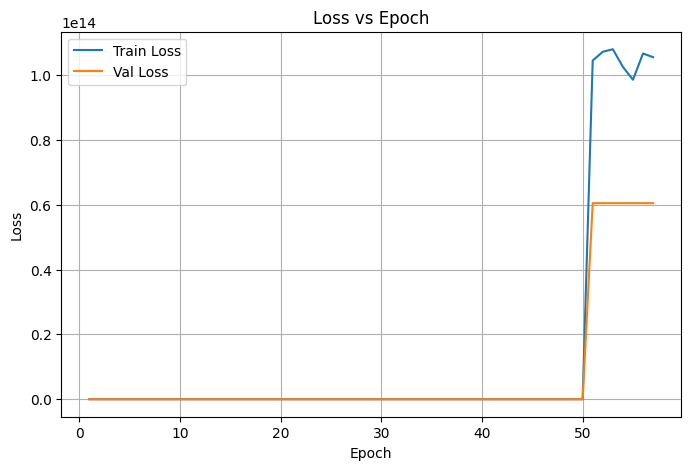

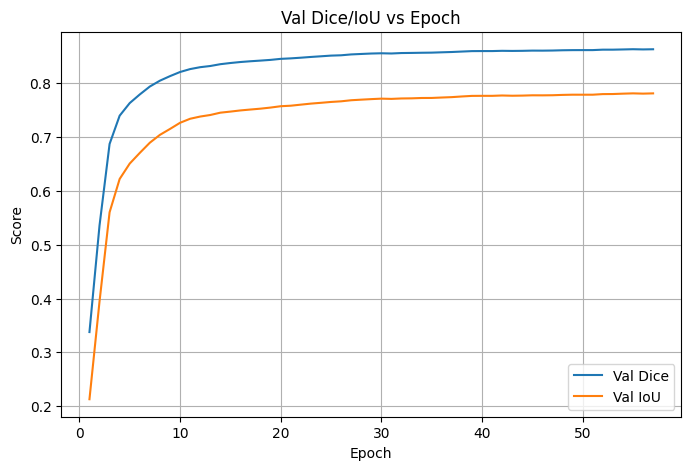

In [10]:
# ==========================================
# Cell 9: Plot training & validation curves
# ==========================================
import matplotlib.pyplot as plt
import pandas as pd

log_path = LOG_CSV
assert os.path.exists(log_path), f"Log CSV not found at {log_path}"

df = pd.read_csv(log_path)
print(df.tail(5))

# After reading df in Cell 9:
cols = ["train_main","train_boundary","train_sdm","train_aux","train_art","train_derm","train_abcd"]
plt.figure(figsize=(10,5))
for c in cols:
    if c in df.columns:
        plt.plot(df["epoch"], df[c], label=c)
plt.xlabel("Epoch"); plt.ylabel("Avg component loss"); plt.title("Train component losses")
plt.legend(); plt.grid(True); plt.show()


# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["train_loss"], label="Train Loss")
plt.plot(df["epoch"], df["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss vs Epoch"); plt.legend(); plt.grid(True)
plt.show()

# Plot Val Dice/IoU
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["val_dice"], label="Val Dice")
plt.plot(df["epoch"], df["val_iou"],  label="Val IoU")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title("Val Dice/IoU vs Epoch"); plt.legend(); plt.grid(True)
plt.show()


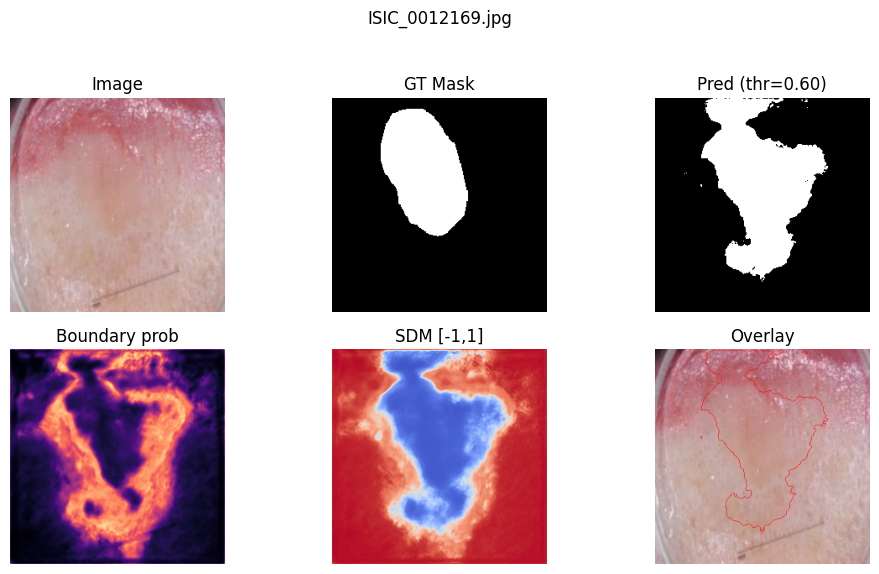

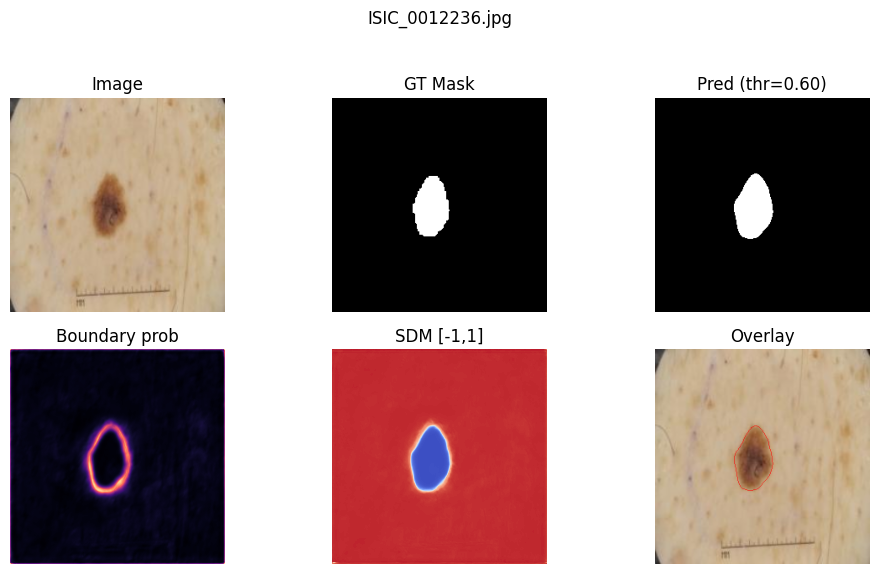

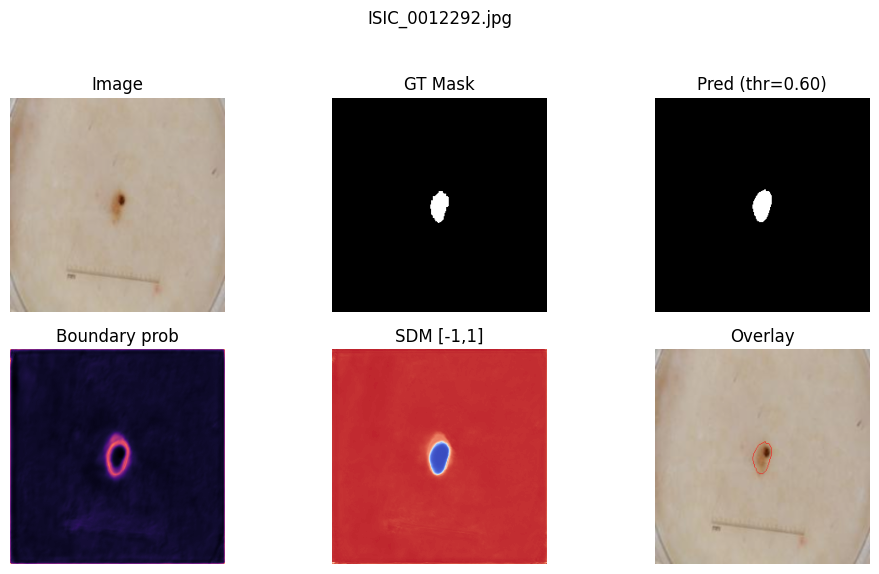

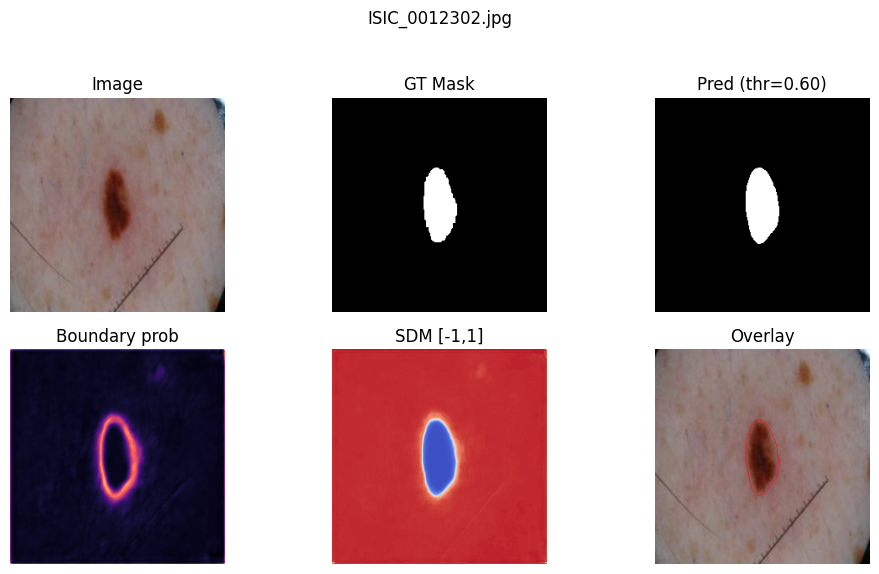

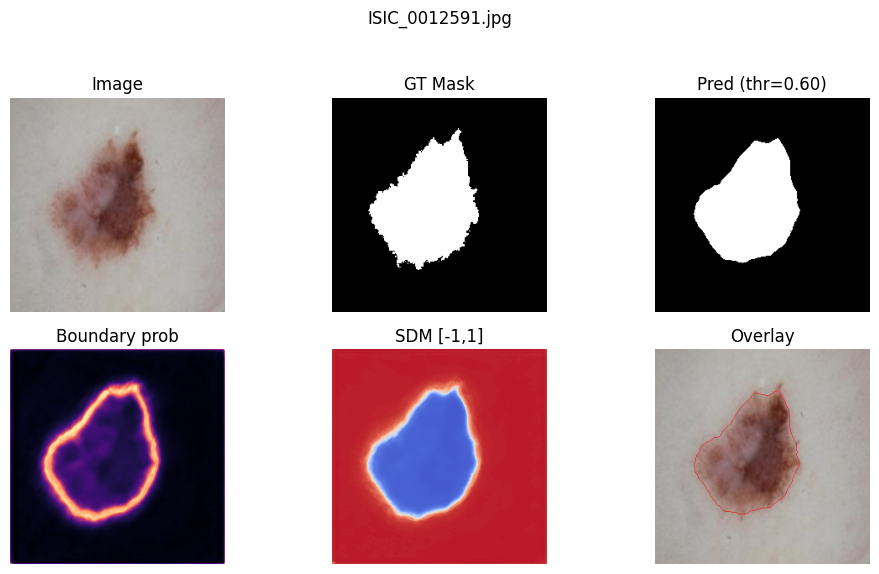

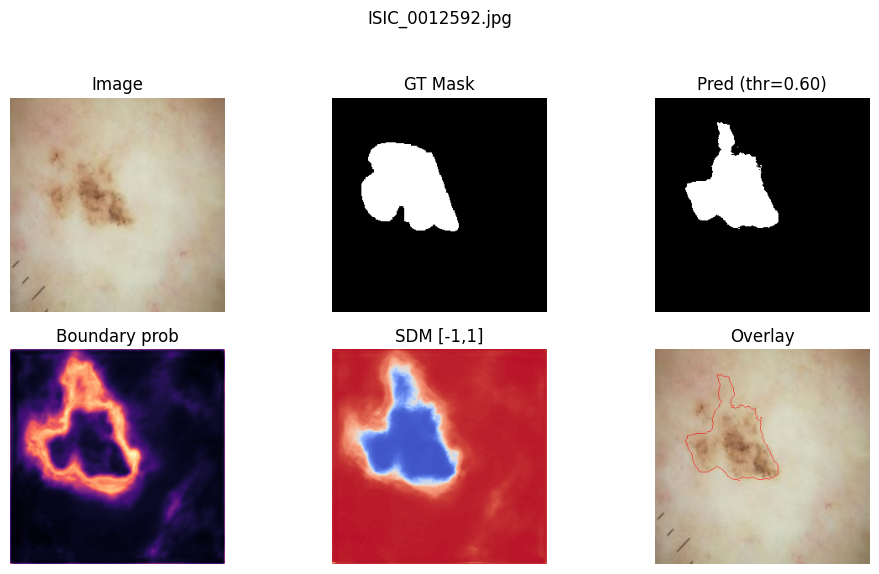

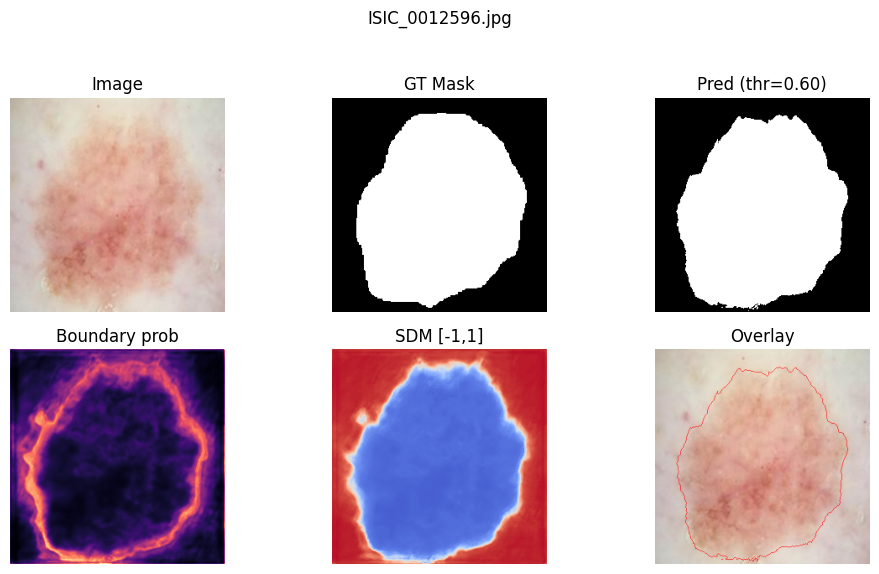

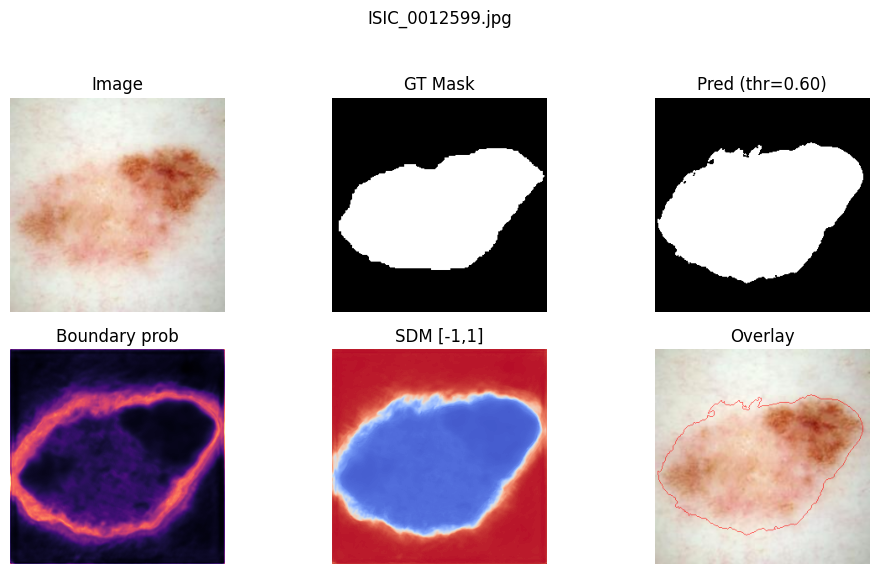

Saved visualizations to: /kaggle/working/vis


In [11]:
# ============================================================
# Cell 10: Qualitative visualization on a few test samples
# ============================================================
import matplotlib.pyplot as plt

VIS_DIR = f"{BASE_DIR}/vis"
os.makedirs(VIS_DIR, exist_ok=True)

@torch.no_grad()
def visualize_batch(loader, max_batches=2, T=1.0, thr=None, save_dir=VIS_DIR):
    model.eval()
    shown = 0
    for imgs, msks, arts, derms, names in loader:
        imgs = imgs.to(device)
        out  = model(imgs)
        fused_logits = fuse_with_geometry(out["logits"], out["sdm"], out["boundary_logits"])
        logits = fused_logits / T
        probs  = torch.sigmoid(logits)
        if thr is None:
            thr_use = 0.5
        else:
            thr_use = float(thr)
        preds  = (probs > thr_use).float()

        bp  = torch.sigmoid(out["boundary_logits"]).cpu().numpy()
        sdm = torch.tanh(out["sdm"]).cpu().numpy()
        pr  = probs.cpu().numpy()
        pdm = preds.cpu().numpy()
        gt  = msks.numpy()
        im  = imgs.cpu().numpy()

        # Denormalize for display
        mean = np.array([0.485, 0.456, 0.406]).reshape(1,3,1,1)
        std  = np.array([0.229, 0.224, 0.225]).reshape(1,3,1,1)
        im_disp = (im * std + mean).clip(0,1)

        for i in range(min(len(names), 4)):
            fig = plt.figure(figsize=(10,6))
            plt.suptitle(names[i], fontsize=12)

            ax1 = plt.subplot(2,3,1); ax1.imshow(np.transpose(im_disp[i], (1,2,0))); ax1.set_title("Image"); ax1.axis("off")
            ax2 = plt.subplot(2,3,2); ax2.imshow(gt[i,0], cmap="gray"); ax2.set_title("GT Mask"); ax2.axis("off")
            ax3 = plt.subplot(2,3,3); ax3.imshow(pdm[i,0], cmap="gray"); ax3.set_title(f"Pred (thr={thr_use:.2f})"); ax3.axis("off")
            ax4 = plt.subplot(2,3,4); ax4.imshow(bp[i,0], cmap="magma"); ax4.set_title("Boundary prob"); ax4.axis("off")
            ax5 = plt.subplot(2,3,5); ax5.imshow(sdm[i,0], cmap="coolwarm", vmin=-1, vmax=1); ax5.set_title("SDM [-1,1]"); ax5.axis("off")
            ax6 = plt.subplot(2,3,6)
            # Overlay prediction contour on image
            img_rgb = np.transpose(im_disp[i], (1,2,0)).copy()
            overlay = img_rgb.copy()
            contour = pdm[i,0].astype(np.uint8)*255
            contours, _ = cv2.findContours(contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(overlay, contours, -1, (1.0, 0.0, 0.0), 1)
            alpha = 0.6
            viz = (alpha*overlay + (1-alpha)*img_rgb).clip(0,1)
            ax6.imshow(viz); ax6.set_title("Overlay"); ax6.axis("off")

            out_path = os.path.join(save_dir, f"{os.path.splitext(names[i])[0]}_viz.png")
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.savefig(out_path, dpi=120)
            plt.show()
        shown += 1
        if shown >= max_batches:
            break

visualize_batch(test_loader, max_batches=2, T=best_T, thr=best_thr)
print(f"Saved visualizations to: {VIS_DIR}")


In [12]:
# =========================================================================
# Cell 11: Robustness analysis on artifact-heavy vs. clean test subsets
# =========================================================================
@torch.no_grad()
def evaluate_subset_by_artifacts(loader, T=1.0, thr=0.5, hair_thr=0.005, ruler_thr=0.003, spec_thr=0.002):
    """
    hair_thr/ruler_thr/spec_thr are fraction of pixels (e.g., 0.005 = 0.5%) to flag as 'heavy'.
    Returns metrics for:
      - hair-heavy
      - ruler-heavy
      - specular-heavy
      - clean (none heavy)
    """
    model.eval()
    sums = {
        "hair": {"d":0.0,"j":0.0,"n":0},
        "ruler":{"d":0.0,"j":0.0,"n":0},
        "spec": {"d":0.0,"j":0.0,"n":0},
        "clean":{"d":0.0,"j":0.0,"n":0}
    }
    for imgs, msks, arts, _, _ in tqdm(loader, desc="Artifact-slice eval"):
        imgs, msks, arts = imgs.to(device), msks.to(device), arts.to(device)
        with torch.no_grad():
            out = model(imgs)
            logits = fuse_with_geometry(out["logits"], out["sdm"], out["boundary_logits"]) / T

        # compute mask metrics per image so we can route to buckets
        probs = torch.sigmoid(logits)
        preds = (probs > thr).float()

        # per-image dice/iou
        tp = (preds*msks).sum((2,3)); fp = (preds*(1-msks)).sum((2,3)); fn = ((1-preds)*msks).sum((2,3))
        dice = (2*tp+1e-6)/(2*tp+fp+fn+1e-6)
        iou  = (tp+1e-6)/(tp+fp+fn+1e-6)

        # artifact fractions
        hair_frac = arts[:,0].mean(dim=(1,2))
        ruler_frac= arts[:,1].mean(dim=(1,2))
        spec_frac = arts[:,2].mean(dim=(1,2))

        for i in range(imgs.size(0)):
            d_i = float(dice[i].item())
            j_i = float(iou[i].item())
            bucket = None
            if hair_frac[i].item() > hair_thr: bucket = "hair"
            elif ruler_frac[i].item() > ruler_thr: bucket = "ruler"
            elif spec_frac[i].item() > spec_thr: bucket = "spec"
            else: bucket = "clean"
            sums[bucket]["d"] += d_i
            sums[bucket]["j"] += j_i
            sums[bucket]["n"] += 1

    results = {}
    for k,v in sums.items():
        n = max(1, v["n"])
        results[k] = {"dice": v["d"]/n, "iou": v["j"]/n, "count": v["n"]}
    return results


# --- REPLACE your current call at the bottom of Cell 11 ---
rob_res = evaluate_subset_by_artifacts(
    test_loader, T=best_T, thr=best_thr,
    hair_thr=0.015,    # was 0.005
    ruler_thr=0.010,   # was 0.003
    spec_thr=0.008     # was 0.002
)

print("Artifact robustness results:")
for k, r in rob_res.items():
    print(f"  {k:>6}: Dice={r['dice']:.4f}, IoU={r['iou']:.4f}, N={r['count']}")


Artifact-slice eval: 100%|██████████| 56/56 [00:10<00:00,  5.18it/s]

Artifact robustness results:
    hair: Dice=0.8765, IoU=0.8101, N=509
   ruler: Dice=0.9305, IoU=0.8790, N=56
    spec: Dice=0.8814, IoU=0.8094, N=31
   clean: Dice=0.8330, IoU=0.7506, N=404


Collect for calibration: 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


ECE (val) with T=0.500: 0.6867


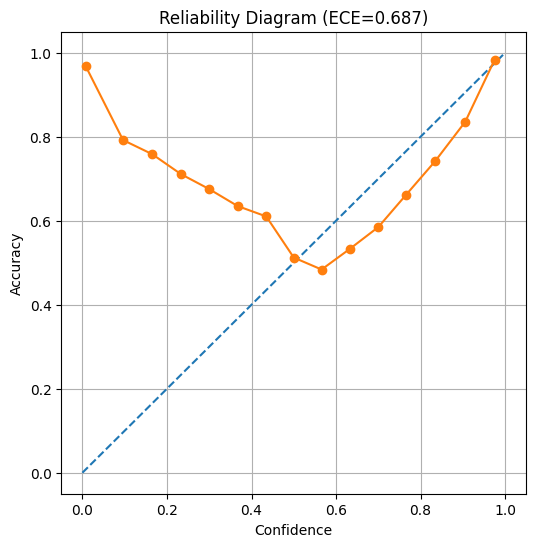

In [13]:
# =======================================================
# Cell 12 (revised): Calibration — better ECE variants
# =======================================================
import matplotlib.pyplot as plt

@torch.no_grad()
def collect_probs_targets(loader, T=1.0):
    model.eval()
    all_probs = []; all_targs = []
    for batch in tqdm(loader, desc="Collect for calibration"):
        if batch is None: 
            continue
        imgs, msks = batch[0].to(device), batch[1].to(device)
        out  = model(imgs)
        logits = fuse_with_geometry(out["logits"], out["sdm"], out["boundary_logits"]) / T
        probs  = torch.sigmoid(logits).detach().cpu()
        targs  = msks.detach().cpu()
        all_probs.append(probs); all_targs.append(targs)
    P = torch.cat(all_probs, dim=0).view(-1)  # 1D
    Y = torch.cat(all_targs, dim=0).view(-1)  # 1D
    return P, Y

def ece_predclass(probs, targets, n_bins=15):
    preds = (probs >= 0.5)
    confs = torch.where(preds, probs, 1.0 - probs)
    bins = torch.linspace(0., 1., n_bins+1)
    ece = 0.0; accs=[]; confm=[]; counts=[]
    N = float(probs.numel())
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        m = (confs >= lo) & (confs < hi)
        n = int(m.sum().item())
        if n == 0:
            accs.append(0.0); confm.append(float((lo+hi)/2)); counts.append(0); continue
        acc = preds[m].eq(targets[m]).float().mean().item()
        c   = confs[m].mean().item()
        ece += (n / N) * abs(acc - c)
        accs.append(acc); confm.append(c); counts.append(n)
    return ece, (accs, confm, counts)

def ece_foreground(probs, targets, n_bins=15):
    m = (targets == 1)
    if m.sum() == 0:
        return 0.0, ([], [], [])
    probs_fg = probs[m]; t_fg = targets[m]
    bins = torch.linspace(0., 1., n_bins+1)
    ece = 0.0; accs=[]; confm=[]; counts=[]
    N = float(probs_fg.numel())
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        b = (probs_fg >= lo) & (probs_fg < hi)
        n = int(b.sum().item())
        if n == 0:
            accs.append(0.0); confm.append(float((lo+hi)/2)); counts.append(0); continue
        conf = probs_fg[b].mean().item()
        acc  = t_fg[b].float().mean().item()  # proportion of 1s
        ece += (n / N) * abs(acc - conf)
        accs.append(acc); confm.append(conf); counts.append(n)
    return ece, (accs, confm, counts)

@torch.no_grad()
def fit_temperature_for_ece(val_loader, mode="predclass", n_bins=15):
    ema.apply_to(model); model.eval()
    temps = torch.linspace(0.5, 2.0, 16, device=device)
    best_T, best_e = 1.0, 1e9
    for T in temps:
        P, Y = collect_probs_targets(val_loader, T=float(T))
        if mode == "predclass":
            e, _ = ece_predclass(P, Y, n_bins=n_bins)
        else:
            e, _ = ece_foreground(P, Y, n_bins=n_bins)
        if e < best_e: best_e, best_T = float(e), float(T.item())
    print(f"Fitted T_cal={best_T:.3f} for {mode}-ECE={best_e:.4f}")
    return best_T

# Collect with Dice-optimal temperature
P, Y = collect_probs_targets(val_loader, T=best_T)

ece_pc, (accs_pc, confs_pc, _) = ece_predclass(P, Y, n_bins=15)
ece_fg, (accs_fg, confs_fg, _) = ece_foreground(P, Y, n_bins=15)
print(f"PredClass-ECE (val) with T={best_T:.3f}: {ece_pc:.4f}")
print(f"Foreground-ECE (val) with T={best_T:.3f}: {ece_fg:.4f}")

# Optional: fit calibration-optimal temperature
T_cal = fit_temperature_for_ece(val_loader, mode="predclass", n_bins=15)

# Reliability diagram (predicted-class)
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],'--')
plt.plot(confs_pc, accs_pc, marker="o")
plt.xlabel("Confidence"); plt.ylabel("Accuracy")
plt.title(f"Reliability (PredClass) — ECE={ece_pc:.3f}, T_dice={best_T:.2f}, T_cal={T_cal:.2f}")
plt.grid(True); plt.show()
